## Setup

In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 34.2 MB/s 
     |████████████████████████████████| 9.9 MB 46.4 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd

keras = tf.keras

In [ ]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)



def sequential_window_dataset(series, window_size):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(1).prefetch(1)
    
def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)

    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    # for x,y in ds:
    #   print(x.numpy(),y.numpy())
    return ds.batch(batch_size).prefetch(1)
  

def model_forecast(model, series, window_size):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    # for x in ds:
    #   print(x.numpy())
    # ds = ds.map(lambda w: (w[:-1], w[1:]))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [ ]:
# time = np.arange(5.5 * 365 + 1.5)


## Preprocessing With 1D-Convolutional Layers

In [ ]:
import pandas as pd
import numpy as np


                   Open
Date                   
2017-09-12  8192.000000
2017-09-13  8161.899902
2017-09-14  8139.950195
2017-09-15  8076.950195
2017-09-18  8130.700195
...                 ...
2022-09-05  8900.000000
2022-09-06  8984.299805
2022-09-07  8864.000000
2022-09-08  8829.000000
2022-09-09  8834.650391

[1235 rows x 1 columns]
(1235, 1)


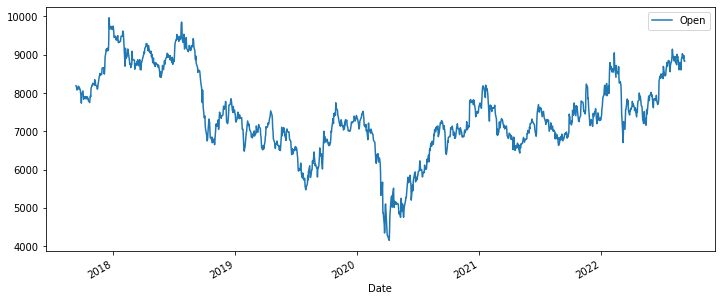

In [ ]:
df=pd.read_csv('/MARUTI.NS.csv')#,index_col='Date',parse_dates=True)
df=pd.DataFrame(df)
df['Date'] = pd.to_datetime(df['Date'],infer_datetime_format=True)
df = df.set_index(['Date'])

# df=df[df.City=="Delhi"]
# df=df[['AQI']]
# df.AEP=df['AEP']/1000000000
# df=df[df['AEP']>150 ]
# df=df[df['AEP']<400]
df=df[['Open']]
df=df.fillna(method='bfill')
df.plot(figsize=(12,5))
print(df)

print(df.shape)


In [ ]:
time = np.arange(df.count().Open)
time

array([   0,    1,    2, ..., 1232, 1233, 1234])

In [ ]:
npp=df['Open'].to_numpy()
split_time = 900

time_train = time[:split_time]
x_train = npp[:split_time]
time_valid = time[split_time:1100]
x_valid = npp[split_time:1100]
x_test=npp[1100:]
test_time=time[1100:]
test_time_1=time[1099:]
npp.shape

(1235,)

In [ ]:
time

array([   0,    1,    2, ..., 1232, 1233, 1234])

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(npp, window_size,
                                   batch_size=128)
print(train_set)
model = keras.models.Sequential([
  keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.LSTM(32, return_sequences=True),
  
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 6500)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mape"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))>
Epoch 1/100
10/10 [==============================] - 14s 82ms/step - loss: 8916.7871 - mape: 120.6033 - lr: 1.0000e-08
Epoch 2/100
10/10 [==============================] - 0s 10ms/step - loss: 8593.8311 - mape: 116.1479 - lr: 1.1220e-08
Epoch 3/100
10/10 [==============================] - 0s 9ms/step - loss: 6872.1377 - mape: 92.5684 - lr: 1.2589e-08
Epoch 4/100
10/10 [==============================] - 0s 10ms/step - loss: 6156.5430 - mape: 82.7218 - lr: 1.4125e-08
Epoch 5/100
10/10 [==============================] - 0s 9ms/step - loss: 5565.2778 - mape: 74.5736 - lr: 1.5849e-08
Epoch 6/100
10/10 [==============================] - 0s 12ms/step - loss: 4877.7983 - mape: 65.0481 - lr: 1.7783e-08
Epoch 7/100
10/10 [==============================] - 0s 11ms/step - loss: 4126.3105 - mape: 54.6387 - lr: 1.9953e-08
Epoch 8/100
10/10 [=

(1e-08, 0.001, 0.0, 800.0)

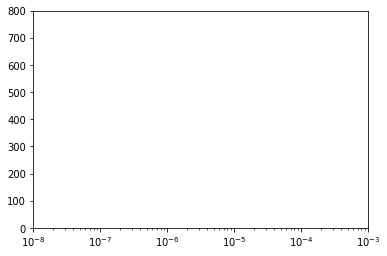

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 800])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 32)          192       
                                                                 
 lstm (LSTM)                 (None, None, 32)          8320      
                                                                 
 lstm_1 (LSTM)               (None, None, 32)          8320      
                                                                 
 dense (Dense)               (None, None, 1)           33        
                                                                 
 lambda (Lambda)             (None, None, 1)           0         
                                                                 
Total params: 16,865
Trainable params: 16,865
Non-trainable params: 0
_________________________________________________________________


In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.LSTM(32, return_sequences=True),
  
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 150)
])
optimizer = keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mape"])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
7/7 [==============================] - 4s 153ms/step - loss: 7259.4468 - mape: 98.7113 - val_loss: 7034.9272 - val_mape: 95.3531
Epoch 2/500
7/7 [==============================] - 0s 22ms/step - loss: 6717.8350 - mape: 91.1529 - val_loss: 6231.4419 - val_mape: 84.4341
Epoch 3/500
7/7 [==============================] - 0s 20ms/step - loss: 5560.9097 - mape: 74.9482 - val_loss: 4407.5625 - val_mape: 59.6459
Epoch 4/500
7/7 [==============================] - 0s 23ms/step - loss: 3226.7610 - mape: 42.4322 - val_loss: 1443.3760 - val_mape: 19.3519
Epoch 5/500
7/7 [==============================] - 0s 21ms/step - loss: 1295.3114 - mape: 18.0575 - val_loss: 1241.7307 - val_mape: 17.1907
Epoch 6/500
7/7 [==============================] - 0s 18ms/step - loss: 1573.5452 - mape: 23.9364 - val_loss: 1174.3733 - val_mape: 16.2657
Epoch 7/500
7/7 [==============================] - 0s 21ms/step - loss: 1259.8926 - mape: 18.6725 - val_loss: 477.3309 - val_mape: 6.4019
Epoch 8/500
7/7 [====

In [ ]:
model = keras.models.load_model("my_checkpoint.h5")

In [ ]:
rnn_forecast_1 = model_forecast(model, npp, window_size)
rnn_forecast_1 = rnn_forecast_1[1100 - window_size:-1, -1, 0]
rnn_forecast_1

38/38 [==============================] - 0s 7ms/step


array([7206.202, 7206.202, 7206.202, 7206.202, 7206.202, 7206.202,
       7206.202, 7206.202, 7206.202, 7206.202, 7206.202, 7206.202,
       7206.202, 7206.202, 7206.202, 7206.202, 7206.202, 7206.202,
       7206.202, 7206.202, 7206.202, 7206.202, 7206.202, 7206.202,
       7206.202, 7206.202, 7206.202, 7206.202, 7206.202, 7206.202,
       7206.202, 7206.202, 7206.202, 7206.202, 7206.202, 7206.202,
       7206.202, 7206.202, 7206.202, 7206.202, 7206.202, 7206.202,
       7206.202, 7206.202, 7206.202, 7206.202, 7206.202, 7206.202,
       7206.202, 7206.202, 7206.202, 7206.202, 7206.202, 7206.202,
       7206.202, 7206.202, 7206.202, 7206.202, 7206.202, 7206.202,
       7206.202, 7206.202, 7206.202, 7206.202, 7206.202, 7206.202,
       7206.202, 7206.202, 7206.202, 7206.202, 7206.202, 7206.202,
       7206.202, 7206.202, 7206.202, 7206.202, 7206.202, 7206.202,
       7206.202, 7206.202, 7206.202, 7206.202, 7206.202, 7206.202,
       7206.202, 7206.202, 7206.202, 7206.202, 7206.202, 7206.

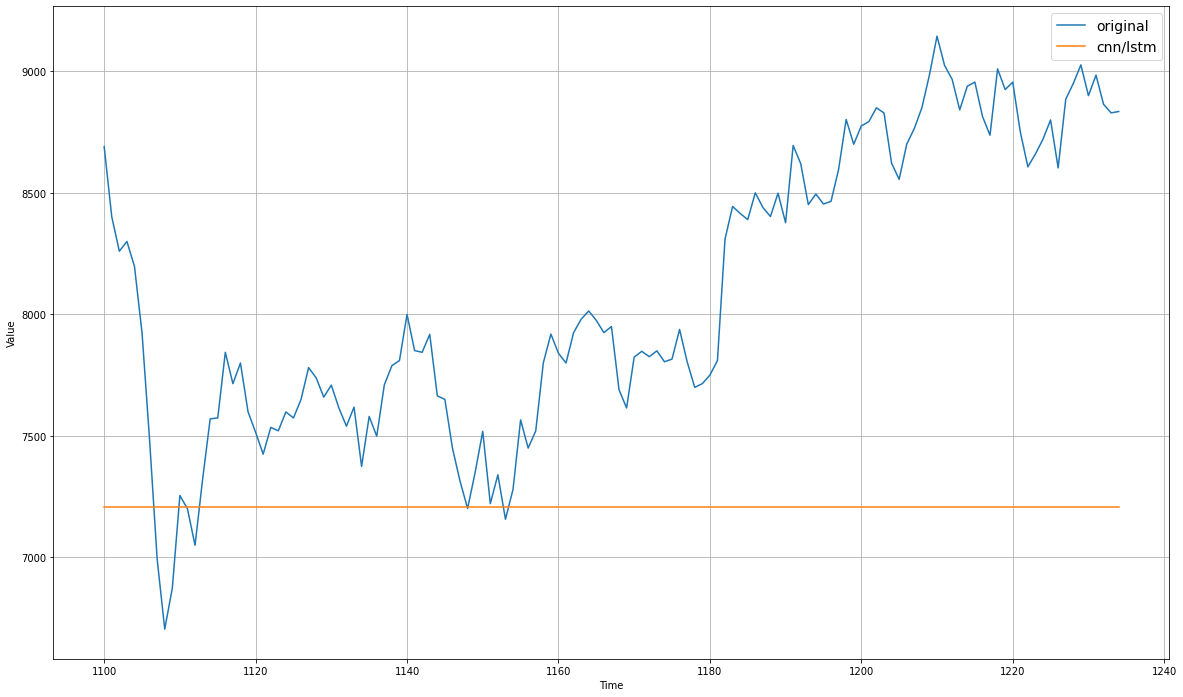

In [ ]:
plt.figure(figsize=(20, 12))
plot_series(test_time, x_test,label='original')
plot_series(test_time, rnn_forecast_1,label='cnn/lstm')

In [ ]:
data_metrics=np.zeros(shape=(4, 5))
metrics_table=pd.DataFrame(data_metrics,index=['MAPE','MAE','MSE','MSLE'],columns=['1D convo preprocessing with Lstm','Fully convo forecasting','LSTM','Lstm preprocessing with 1d convo','SARIMA'])

In [ ]:
metrics_table.iloc[0,0]=keras.metrics.mean_absolute_percentage_error(x_test, rnn_forecast_1).numpy()
metrics_table.iloc[1,0]=keras.metrics.mae(x_test, rnn_forecast_1).numpy()
metrics_table.iloc[2,0]=keras.metrics.mse(x_test, rnn_forecast_1).numpy()
metrics_table.iloc[3,0]=keras.metrics.msle(x_test, rnn_forecast_1).numpy()
metrics_table

,1D convo preprocessing with Lstm,Fully convo forecasting,LSTM,Lstm preprocessing with 1d convo,SARIMA
MAPE,1.061756e+01,0.0,0.0,0.0,0.0
MAE,8.934399e+02,0.0,0.0,0.0,0.0
MSE,1.114602e+06,0.0,0.0,0.0,0.0
MSLE,1.788233e-02,0.0,0.0,0.0,0.0


## Fully Convolutional Forecasting

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 64
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 30))
optimizer = keras.optimizers.Adam(lr=1e-6)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mape"])
history = model.fit(train_set, epochs=200, callbacks=[lr_schedule])

Epoch 1/200


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


7/7 [==============================] - 2s 45ms/step - loss: 7420.6460 - mape: 101.0671 - lr: 1.0000e-08
Epoch 2/200
7/7 [==============================] - 0s 7ms/step - loss: 7420.6382 - mape: 101.0670 - lr: 1.0798e-08
Epoch 3/200
7/7 [==============================] - 0s 8ms/step - loss: 7420.6299 - mape: 101.0669 - lr: 1.1659e-08
Epoch 4/200
7/7 [==============================] - 0s 11ms/step - loss: 7420.6206 - mape: 101.0668 - lr: 1.2589e-08
Epoch 5/200
7/7 [==============================] - 0s 7ms/step - loss: 7420.6118 - mape: 101.0667 - lr: 1.3594e-08
Epoch 6/200
7/7 [==============================] - 0s 7ms/step - loss: 7420.6021 - mape: 101.0665 - lr: 1.4678e-08
Epoch 7/200
7/7 [==============================] - 0s 8ms/step - loss: 7420.5928 - mape: 101.0664 - lr: 1.5849e-08
Epoch 8/200
7/7 [==============================] - 0s 8ms/step - loss: 7420.5825 - mape: 101.0662 - lr: 1.7113e-08
Epoch 9/200
7/7 [==============================] - 0s 10ms/step - loss: 7420.5713 - mape: 

(1e-08, 0.1, 0.0, 2000.0)

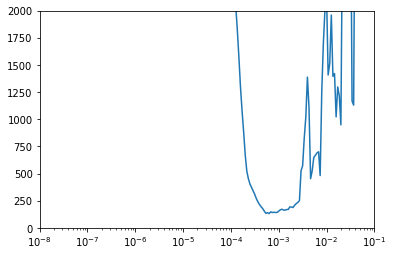

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-1, 0, 2000])

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 64
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
optimizer = keras.optimizers.Adam(lr=1e-3)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mape"])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
history = model.fit(train_set, epochs=500,
                    validation_data=valid_set,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
7/7 [==============================] - 2s 125ms/step - loss: 6762.1997 - mape: 92.0371 - val_loss: 5959.1235 - val_mape: 81.3813
Epoch 2/500
7/7 [==============================] - 0s 22ms/step - loss: 5052.5923 - mape: 68.5133 - val_loss: 3273.2676 - val_mape: 44.9227
Epoch 3/500
7/7 [==============================] - 0s 21ms/step - loss: 3186.7224 - mape: 43.5735 - val_loss: 3146.3357 - val_mape: 43.0605
Epoch 4/500
7/7 [==============================] - 0s 23ms/step - loss: 2921.7085 - mape: 40.1105 - val_loss: 2339.7717 - val_mape: 32.1818
Epoch 5/500
7/7 [==============================] - 0s 21ms/step - loss: 2319.5264 - mape: 31.6212 - val_loss: 1900.1642 - val_mape: 26.1523
Epoch 6/500
7/7 [==============================] - 0s 21ms/step - loss: 1726.8934 - mape: 23.6530 - val_loss: 1223.6572 - val_mape: 16.8777
Epoch 7/500
7/7 [==============================] - 0s 24ms/step - loss: 1017.4687 - mape: 13.9852 - val_loss: 754.0481 - val_mape: 10.3823
Epoch 8/500
7/7 [===

In [ ]:
model = keras.models.load_model("my_checkpoint.h5")

In [ ]:
x_train.shape

(900,)

In [ ]:
cnn_forecast_2 = model_forecast(model, npp, window_size)
print(npp.shape)
# for x in cnn_forecast_2:
#     print(x)
cnn_forecast_2 = cnn_forecast_2[1100- window_size:-1, -1,0]
print(cnn_forecast_2)

37/37 [==============================] - 0s 6ms/step
(1235,)
[8461.702  8687.329  8397.759  8257.623  8316.155  8166.1875 7923.6855
 7452.567  7005.622  6747.4604 6827.924  7274.006  7253.4634 6983.3857
 7259.7817 7498.6387 7533.2617 7773.423  7670.037  7744.884  7540.6895
 7430.3286 7420.9287 7524.5684 7469.8154 7515.321  7524.916  7609.149
 7739.0464 7694.118  7640.3486 7681.9697 7574.8184 7540.742  7625.931
 7377.5273 7594.1504 7515.913  7682.636  7826.5044 7818.863  8043.685
 7855.637  7825.492  7940.528  7700.303  7692.5054 7449.9976 7305.0317
 7204.1465 7339.4365 7531.1807 7253.831  7375.4624 7173.523  7279.7476
 7654.134  7528.897  7638.424  7845.8135 7901.896  7884.9023 7807.791
 7874.0537 7941.8438 7971.1846 7941.4507 7907.3296 7918.49   7663.086
 7592.3354 7806.906  7833.8623 7856.848  7842.9146 7773.5215 7805.5635
 7927.0537 7805.2295 7731.0815 7729.2285 7742.7065 7831.4785 8288.424
 8419.003  8417.32   8370.637  8405.944  8392.971  8368.657  8480.381
 8352.582  8664.704  86

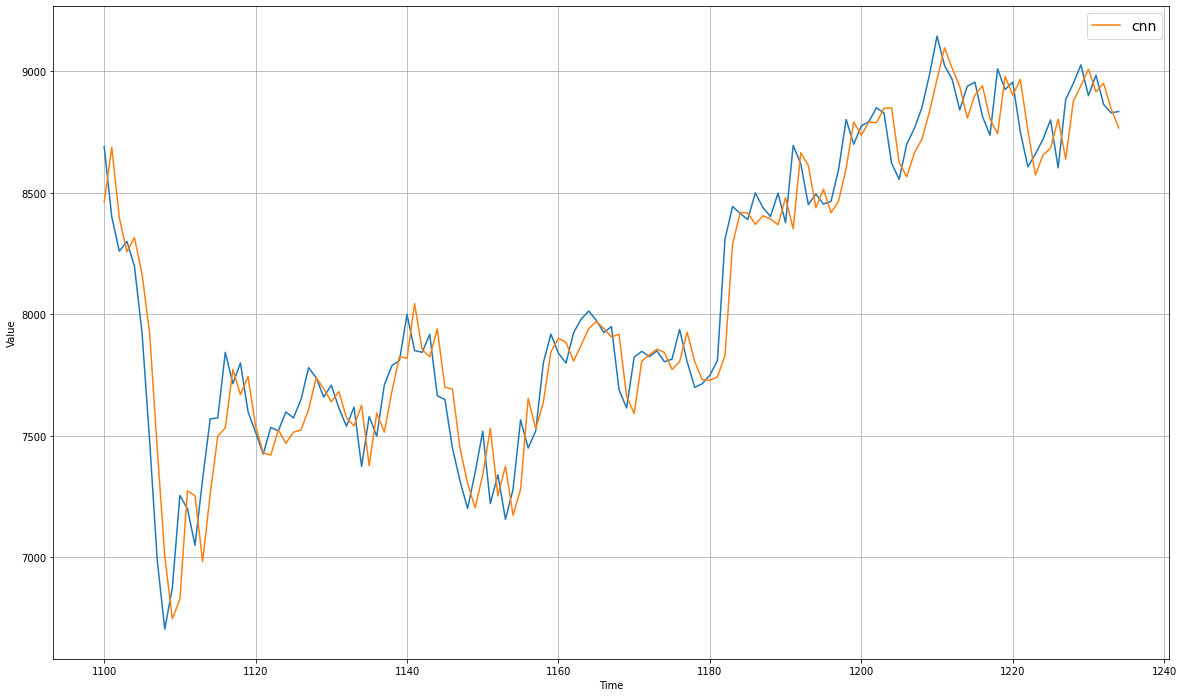

In [ ]:
plt.figure(figsize=(20, 12))
plot_series(test_time, x_test)
plot_series(test_time, cnn_forecast_2,label='cnn')

In [ ]:
metrics_table.iloc[0,1]=keras.metrics.mean_absolute_percentage_error(x_test, cnn_forecast_2).numpy()
metrics_table.iloc[1,1]=keras.metrics.mae(x_test, cnn_forecast_2).numpy()
metrics_table.iloc[2,1]=keras.metrics.mse(x_test, cnn_forecast_2).numpy()
metrics_table.iloc[3,1]=keras.metrics.msle(x_test, cnn_forecast_2).numpy()
metrics_table

,1D convo preprocessing with Lstm,Fully convo forecasting,LSTM,Lstm preprocessing with 1d convo,SARIMA
MAPE,1.061756e+01,1.567754,0.0,0.0,0.0
MAE,8.934399e+02,124.384460,0.0,0.0,0.0
MSE,1.114602e+06,25604.236328,0.0,0.0,0.0
MSLE,1.788233e-02,0.000422,0.0,0.0,0.0


## LSTM

In [ ]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                    batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 300.0)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
reset_states = ResetStatesCallback()
optimizer = keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mape"])
history = model.fit(train_set, epochs=100,
                    callbacks=[lr_schedule, reset_states])

Epoch 1/100


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


29/29 [==============================] - 57s 8ms/step - loss: 7376.7075 - mape: 100.0727 - lr: 1.0000e-08
Epoch 2/100
29/29 [==============================] - 0s 7ms/step - loss: 7364.9756 - mape: 99.9087 - lr: 1.1220e-08
Epoch 3/100
29/29 [==============================] - 0s 8ms/step - loss: 7351.3975 - mape: 99.7185 - lr: 1.2589e-08
Epoch 4/100
29/29 [==============================] - 0s 8ms/step - loss: 7336.0742 - mape: 99.5040 - lr: 1.4125e-08
Epoch 5/100
29/29 [==============================] - 0s 8ms/step - loss: 7318.8486 - mape: 99.2629 - lr: 1.5849e-08
Epoch 6/100
29/29 [==============================] - 0s 8ms/step - loss: 7299.5088 - mape: 98.9922 - lr: 1.7783e-08
Epoch 7/100
29/29 [==============================] - 0s 8ms/step - loss: 7277.8276 - mape: 98.6887 - lr: 1.9953e-08
Epoch 8/100
29/29 [==============================] - 0s 8ms/step - loss: 7253.5742 - mape: 98.3492 - lr: 2.2387e-08
Epoch 9/100
29/29 [==============================] - 0s 8ms/step - loss: 7226.5083

(1e-08, 0.001, 0.0, 500.0)

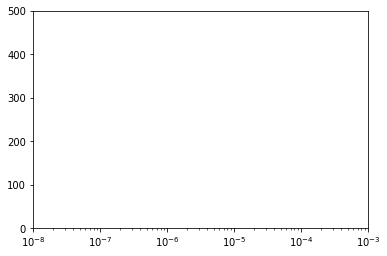

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 500])

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)
valid_set = sequential_window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                         batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 150.0)
])
optimizer = keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mape"])
reset_states = ResetStatesCallback()
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model.fit(train_set, epochs=600,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint, reset_states])

Epoch 1/600
29/29 [==============================] - 3s 36ms/step - loss: 7367.3657 - mape: 99.9387 - val_loss: 7284.0825 - val_mape: 99.7694
Epoch 2/600
29/29 [==============================] - 0s 9ms/step - loss: 7340.3574 - mape: 99.5585 - val_loss: 7254.5723 - val_mape: 99.3642
Epoch 3/600
29/29 [==============================] - 0s 10ms/step - loss: 7310.7720 - mape: 99.1456 - val_loss: 7224.8608 - val_mape: 98.9562
Epoch 4/600
29/29 [==============================] - 0s 11ms/step - loss: 7281.4214 - mape: 98.7363 - val_loss: 7195.6665 - val_mape: 98.5553
Epoch 5/600
29/29 [==============================] - 0s 10ms/step - loss: 7252.6909 - mape: 98.3357 - val_loss: 7167.1797 - val_mape: 98.1641
Epoch 6/600
29/29 [==============================] - 0s 10ms/step - loss: 7224.6909 - mape: 97.9454 - val_loss: 7139.4458 - val_mape: 97.7833
Epoch 7/600
29/29 [==============================] - 0s 9ms/step - loss: 7197.4307 - mape: 97.5653 - val_loss: 7112.4453 - val_mape: 97.4125
Epoch 8/

In [ ]:
model = keras.models.load_model("my_checkpoint.h5")
rnn_forecast_3 = model.predict(npp[np.newaxis, :, np.newaxis])
rnn_forecast_3 = rnn_forecast_3[-1,1099:-1,0]
rnn_forecast_3.shape


1/1 [==============================] - 1s 647ms/step


(135,)

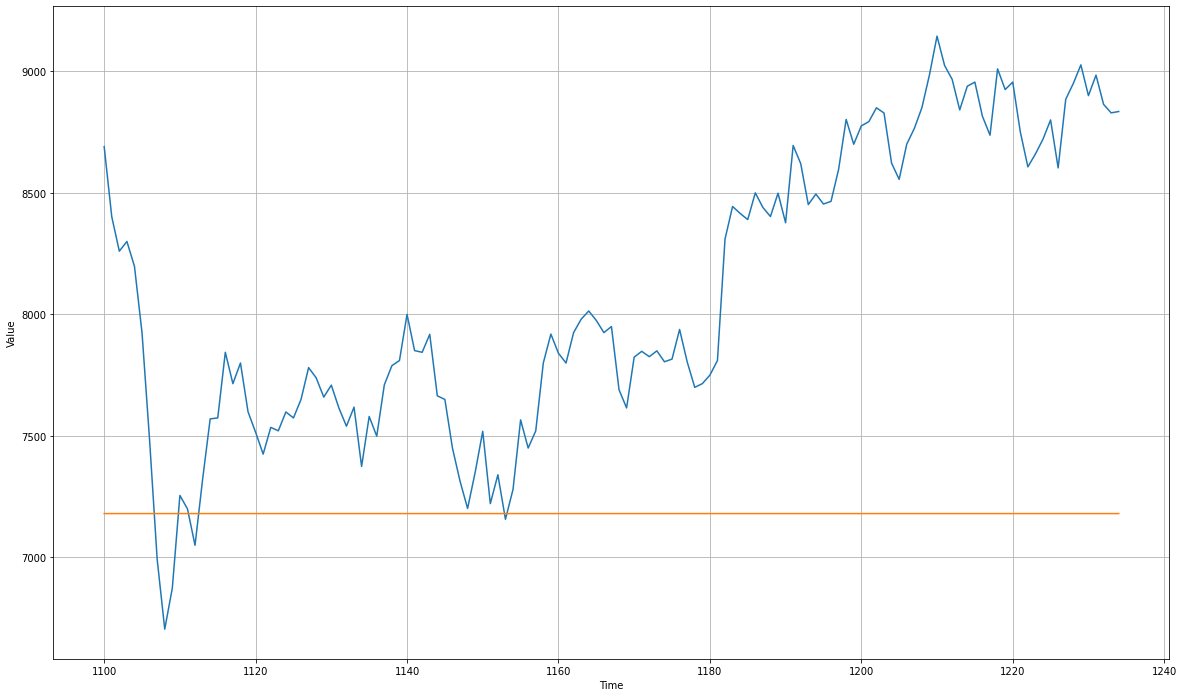

In [ ]:
plt.figure(figsize=(20, 12))
plot_series(test_time, x_test)
plot_series(test_time, rnn_forecast_3)

In [ ]:
metrics_table.iloc[0,2]=keras.metrics.mean_absolute_percentage_error(x_test, rnn_forecast_3).numpy()
metrics_table.iloc[1,2]=keras.metrics.mae(x_test, rnn_forecast_3).numpy()
metrics_table.iloc[2,2]=keras.metrics.mse(x_test, rnn_forecast_3).numpy()
metrics_table.iloc[3,2]=keras.metrics.msle(x_test, rnn_forecast_3).numpy()
metrics_table

,1D convo preprocessing with Lstm,Fully convo forecasting,LSTM,Lstm preprocessing with 1d convo,SARIMA
MAPE,1.061756e+01,1.567754,1.090803e+01,0.0,0.0
MAE,8.934399e+02,124.384460,9.171028e+02,0.0,0.0
MSE,1.114602e+06,25604.236328,1.160277e+06,0.0,0.0
MSLE,1.788233e-02,0.000422,1.869532e-02,0.0,0.0


### Preprocessing with LSTM for FCN

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 64
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
model.add(keras.layers.LSTM(32, return_sequences=True))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
        
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 30))
optimizer = keras.optimizers.Adam(lr=1e-7)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mape"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


7/7 [==============================] - 4s 31ms/step - loss: 7342.3652 - mape: 100.0006 - lr: 1.0000e-04
Epoch 2/100
7/7 [==============================] - 0s 10ms/step - loss: 7342.3281 - mape: 100.0001 - lr: 1.0798e-04
Epoch 3/100
7/7 [==============================] - 0s 11ms/step - loss: 7342.2983 - mape: 99.9997 - lr: 1.1659e-04
Epoch 4/100
7/7 [==============================] - 0s 10ms/step - loss: 7342.2769 - mape: 99.9994 - lr: 1.2589e-04
Epoch 5/100
7/7 [==============================] - 0s 11ms/step - loss: 7342.2559 - mape: 99.9991 - lr: 1.3594e-04
Epoch 6/100
7/7 [==============================] - 0s 12ms/step - loss: 7342.2319 - mape: 99.9988 - lr: 1.4678e-04
Epoch 7/100
7/7 [==============================] - 0s 10ms/step - loss: 7342.2002 - mape: 99.9983 - lr: 1.5849e-04
Epoch 8/100
7/7 [==============================] - 0s 11ms/step - loss: 7342.1572 - mape: 99.9977 - lr: 1.7113e-04
Epoch 9/100
7/7 [==============================] - 0s 12ms/step - loss: 7342.0952 - mape: 

(0.0001, 0.1, 0.0, 500.0)

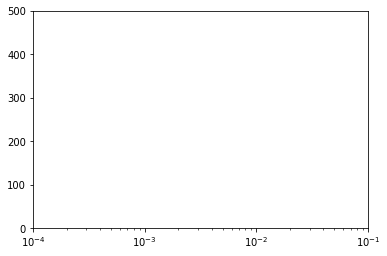

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-4, 1e-1, 0, 500])

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 64
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
model.add(keras.layers.LSTM(32, return_sequences=True))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
optimizer = keras.optimizers.Adam(lr=1e-3)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mape"])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
history = model.fit(train_set, epochs=500,
                    validation_data=valid_set,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
7/7 [==============================] - 4s 225ms/step - loss: 7342.2109 - mape: 99.9985 - val_loss: 7329.3921 - val_mape: 99.9962
Epoch 2/500
7/7 [==============================] - 0s 28ms/step - loss: 7341.8262 - mape: 99.9930 - val_loss: 7328.7095 - val_mape: 99.9869
Epoch 3/500
7/7 [==============================] - 0s 28ms/step - loss: 7340.7207 - mape: 99.9776 - val_loss: 7326.6343 - val_mape: 99.9586
Epoch 4/500
7/7 [==============================] - 0s 26ms/step - loss: 7337.4390 - mape: 99.9317 - val_loss: 7320.7329 - val_mape: 99.8783
Epoch 5/500
7/7 [==============================] - 0s 26ms/step - loss: 7328.0229 - mape: 99.7995 - val_loss: 7303.4937 - val_mape: 99.6438
Epoch 6/500
7/7 [==============================] - 0s 26ms/step - loss: 7300.8140 - mape: 99.4188 - val_loss: 7254.8555 - val_mape: 98.9820
Epoch 7/500
7/7 [==============================] - 0s 28ms/step - loss: 7225.6255 - mape: 98.3670 - val_loss: 7123.8657 - val_mape: 97.2001
Epoch 8/500
7/7 [==

In [ ]:
model=keras.models.load_model('my_checkpoint.h5')
cnn_forecast_4=model_forecast(model,npp,window_size)
cnn_forecast_4=cnn_forecast_4[1100-window_size:-1,-1,0]

37/37 [==============================] - 1s 8ms/step


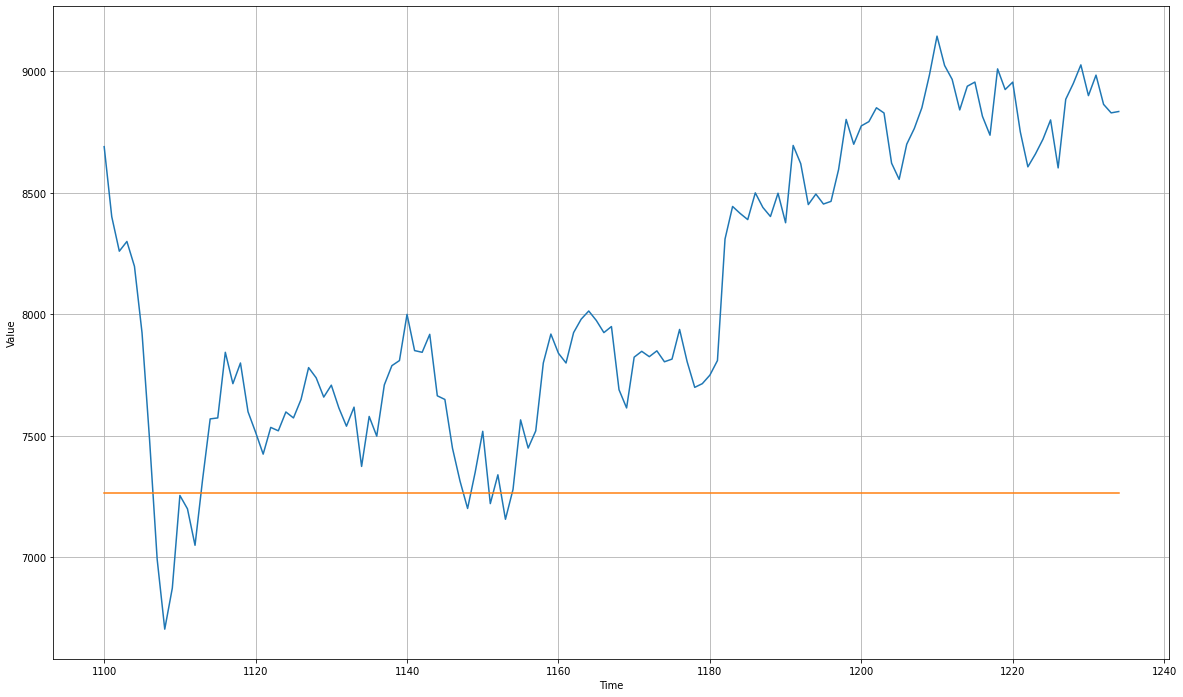

In [ ]:
plt.figure(figsize=(20, 12))
plot_series(test_time, x_test)
plot_series(test_time, cnn_forecast_4)

In [ ]:
metrics_table.iloc[0,3]=keras.metrics.mean_absolute_percentage_error(x_test, cnn_forecast_4).numpy()
metrics_table.iloc[1,3]=keras.metrics.mae(x_test, cnn_forecast_4).numpy()
metrics_table.iloc[2,3]=keras.metrics.mse(x_test, cnn_forecast_4).numpy()
metrics_table.iloc[3,3]=keras.metrics.msle(x_test, cnn_forecast_4).numpy()
metrics_table

,1D convo preprocessing with Lstm,Fully convo forecasting,LSTM,Lstm preprocessing with 1d convo,SARIMA
MAPE,1.061756e+01,1.567754,1.090803e+01,9.975163e+00,0.0
MAE,8.934399e+02,124.384460,9.171028e+02,8.408196e+02,0.0
MSE,1.114602e+06,25604.236328,1.160277e+06,1.013856e+06,0.0
MSLE,1.788233e-02,0.000422,1.869532e-02,1.610710e-02,0.0


In [ ]:
# from pmdarima import auto_arima
# from sklearn.metrics import mean_squared_error
# from math import sqrt

# train=df.iloc[:-800]
# test=df.iloc[-800:]
# stepwise_fit = auto_arima(train, start_p = 1, start_q = 1,
#                           max_p = 5, max_q = 5, #m = 7,
#                           # start_P = 0, seasonal = False,
#                           # d = None, D = 1, trace = True,
#                           error_action ='ignore',   # we don't want to know if an order does not work
#                           suppress_warnings = True,  # we don't want convergence warnings
#                           stepwise = True)           # set to stepwise
  
# # To print the summary
# ab=stepwise_fit.summary()
# print(ab)
# start=len(train)
# end=len(train)+len(test)-1
# pred=stepwise_fit.predict(start=start,end=end,typ='levels').rename('ARIMA Predictions')
# pred.plot(legend=True)
# test['AEP'].plot(legend=True)


In [ ]:
# from statsmodels.tsa.statespace.sarimax import SARIMAX
# from pmdarima import auto_arima
# from sklearn.metrics import mean_squared_error
# from math import sqrt

# train=df.iloc[:-1000]
# test=df.iloc[-1000:-1]
# model=SARIMAX(train['AAPL'],order=(4,1,5),seasonal_order=(2,1,0,7))
# # model=SARIMAX(train['AEP'],order=(5,1,1))
# model=model.fit()
# model.summary()
# start=len(train)
# end=len(train)+len(test)-1
# pred=model.predict(start=start,end=end,typ='levels').rename('ARIMA Predictions')
# pred.plot(legend=True)
# # test['AAPL'].plot(legend=True)

KeyError: ignored

In [ ]:
# print(np.abs(pred).describe())
# print(np.array(test['AAPL']).max)


In [ ]:



# def forecast_accuracy(forecast, actual):
#     metrics_table.iloc[0,4] = np.mean(np.abs(forecast - actual)/np.abs(actual)) *100 # MAPE
#     # # me = np.mean(forecast - actual)             # ME
#     metrics_table.iloc[1,4] = np.mean(np.abs(forecast - actual))    # MAE
#     # # mpe = np.mean((forecast - actual)/actual)   # MPE
#     metrics_table.iloc[2,4] = np.mean((forecast - actual)**2)  # RMSE
#     # msle=keras.metrics.msle()
#     metrics_table.iloc[3,4]='-'
#     # metrics_table.iloc[0,4]=keras.metrics.mean_absolute_percentage_error(actual, forecast).numpy()
#     # metrics_table.iloc[1,4]=keras.metrics.mae(actual,forecast).numpy()
#     # metrics_table.iloc[2,4]=keras.metrics.mse(actual,forecast).numpy()
#     # metrics_table.iloc[3,4]=keras.metrics.msle(actual,forecast).numpy()
    
#     return 0

# forecast_accuracy(pred, np.array(test['AAPL']))
# metrics_table

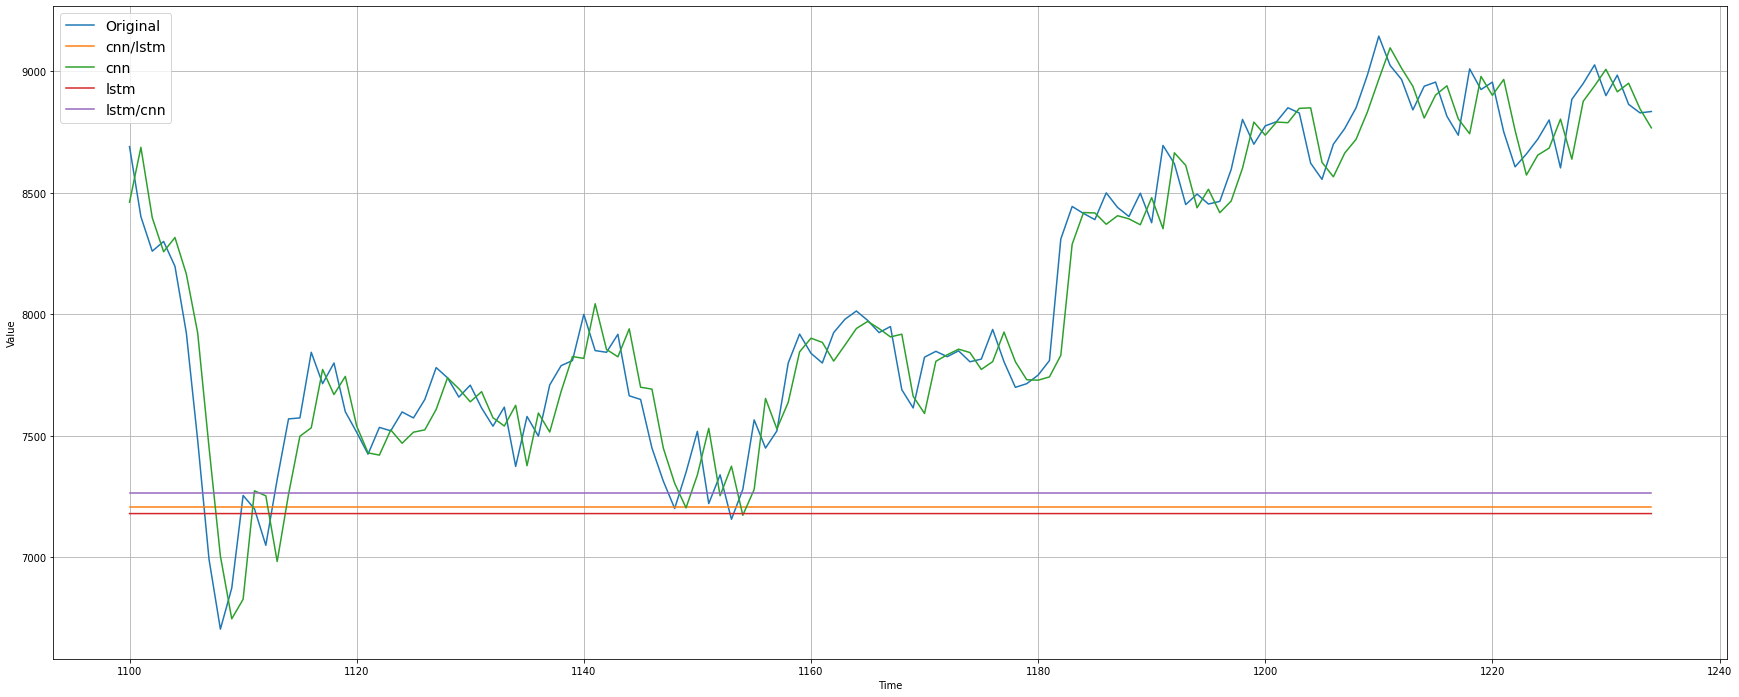

In [ ]:
plt.figure(figsize=(30, 12))
plot_series(test_time, x_test,label='Original')
plot_series(test_time, rnn_forecast_1,label='cnn/lstm')
plot_series(test_time, cnn_forecast_2,label='cnn')
plot_series(test_time, rnn_forecast_3,label='lstm')
plot_series(test_time, cnn_forecast_4,label='lstm/cnn')
# plot_series(test['AAPL'],pred,start=6500,label='arima')
plt.show()


In [ ]:
metrics_table.to_csv('/results_AAPL1.csv')

In [ ]:
metrics_table

,1D convo preprocessing with Lstm,Fully convo forecasting,LSTM,Lstm preprocessing with 1d convo,SARIMA
MAPE,1.061756e+01,1.567754,1.090803e+01,9.975163e+00,0.0
MAE,8.934399e+02,124.384460,9.171028e+02,8.408196e+02,0.0
MSE,1.114602e+06,25604.236328,1.160277e+06,1.013856e+06,0.0
MSLE,1.788233e-02,0.000422,1.869532e-02,1.610710e-02,0.0
